# Logistic Regression Baseline

This notebook establishes a classical ML baseline for financial sentiment analysis using:

-   **TF-IDF vectorization**
-   **Logistic Regression (with class weighting)**
-   **Macro-F1 and per-source evaluation**

This gives us a lightweight, interpretable baseline to compare with transformer-based models.


In [22]:
import sys

sys.path.append("../scripts")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from metrics import per_source_metrics
from plot_utils import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Load Preprocessed Data

We’ll use the stratified training and validation sets saved in the previous step.


In [23]:
train_df = pd.read_csv("../data/processed/train.csv").dropna()
val_df = pd.read_csv("../data/processed/val.csv")

print(f"Train size: {train_df.shape}, Validation size: {val_df.shape}")
print("Columns:", list(train_df.columns), "\n")

display(train_df.head(2))
display(val_df.head(2))

Train size: (16022, 3), Validation size: (1781, 3)
Columns: ['sentence', 'label', 'source'] 



,sentence,label,source
0,EBay selling StubHub to Viagogo for 4 billionplus,neutral,Twitter
1,Dow futures up 73 points or 03 SP 500 futures ...,positive,Twitter


,sentence,label,source
0,The negotiations concern personnel of Cencorp ...,neutral,FPB
1,Hedge Funds Are Dumping Ocwen Financial Corpor...,negative,Twitter


## Using Logistic Regression

We’ll use `LogisticRegression` from `sklearn` with class weighting to handle class imbalance. We’ll also use `TfidfVectorizer` for text vectorization.


### TF-IDF Vectorization

We use unigrams and bigrams (`ngram_range=(1, 2)`) and limit to the top 5,000 features.


In [24]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df["sentence"])
X_val = vectorizer.transform(val_df["sentence"])

print(f"TF-IDF matrix shape: {X_train.shape}")

TF-IDF matrix shape: (16022, 5000)


### Train Logistic Regression

We use `class_weight="balanced"` to handle any class imbalance.


In [25]:
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train, train_df["label"])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluation

We evaluate on:

-   **Macro F1-score** (equal weight to all classes)
-   **Accuracy**
-   **Per-source performance** (e.g., FPB vs Twitter vs FiQA)


### Per-Source Evaluation

We calculate macro F1-score and accuracy for each source in the validation set. This helps us understand how the model performs across different data sources.


In [26]:
val_preds = clf.predict(X_val)
# val_probs = clf.predict_proba(X_val) #TODO

# Print metrics by dataset source
lr_results = per_source_metrics(val_df["label"], val_preds, val_df["source"])
print("Per-Source Metrics (Logistic Regression):\n")
for source, acc, f1 in lr_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

Per-Source Metrics (Logistic Regression):

FPB: Accuracy=0.706, Macro-F1=0.661
Twitter: Accuracy=0.777, Macro-F1=0.721
FiQA: Accuracy=0.685, Macro-F1=0.585


### Classification Report

We generate a classification report with precision, recall, F1-score, and support for each class, and overall accuracy.


In [27]:
report = classification_report(val_df["label"], val_preds)
print("Full Report:\n")
print(report)

Full Report:

              precision    recall  f1-score   support

    negative       0.57      0.70      0.63       274
     neutral       0.86      0.79      0.82      1064
    positive       0.65      0.69      0.67       443

    accuracy                           0.75      1781
   macro avg       0.69      0.73      0.71      1781
weighted avg       0.77      0.75      0.76      1781



### Confusion Matrix

Visualizing misclassifications across classes helps us understand where the model struggles.


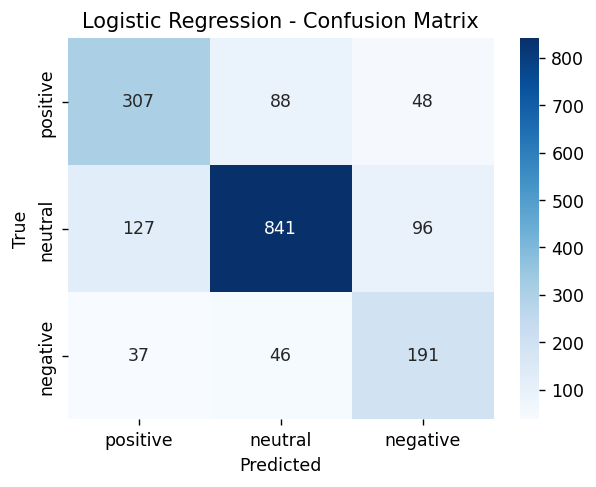

In [28]:
plot_confusion_matrix(
    y_true=val_df["label"],
    y_pred=val_preds,
    labels=["positive", "neutral", "negative"],
    title="Logistic Regression - Confusion Matrix",
    cmap="Blues",
)

## Save Outputs

We’ll save:

-   TF-IDF vectorizer
-   Trained model
-   Classification report CSV and text predictions


In [29]:
import pickle

from sklearn.metrics import classification_report

with open("../models/lr/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("../models/lr/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf, f)

pd.DataFrame(
    classification_report(val_df["label"], val_preds, output_dict=True)
).transpose().to_csv(
    "../models/lr/lr-preds.csv"
)  # saving classification report as CSV

with open("../models/lr/lr-preds.txt", "w") as f:  # saving text predictions
    for item in val_preds:
        f.write(item + "\n")

## Summary

We trained a TF-IDF + Logistic Regression baseline model with the following results:

-   Macro-F1: Reported by class and source
-   Useful as a simple, interpretable baseline
-   All outputs saved in `/models/lr`

Next: Try transformer-based models like **FinBERT** in **[3_finbert_inference.ipynb](3_finbert_inference.ipynb)**.
